In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import requests
import torchvision

In [2]:
# --- Гиперпараметры ---
BATCH_SIZE = 64
LATENT_DIM = 128
IMAGE_SIZE = 128  # Можно менять: 64, 128, 256 (должно делиться на 16)
EPOCHS = 30
LEARNING_RATE = 1e-3
SAVE_PATH = 'vae_model.pth'
OLD_MODEL = False  # Указать путь к модели для загрузки, если нужно

In [3]:
# --- Устройство ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# --- Подготовка данных ---
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

In [5]:
dataset = datasets.ImageFolder(root='data', transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Loaded {len(dataset)} images from 'data'")

Loaded 1800 images from 'data'


In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        assert img_size % 16 == 0, "IMAGE_SIZE должно быть кратно 16"

        num_layers = int(torch.log2(torch.tensor(img_size // 4)))
        layers = []
        in_channels = 3

        for _ in range(num_layers):
            out_channels = in_channels * 2
            layers.append(nn.Conv2d(in_channels, out_channels, 4, 2, 1))
            layers.append(nn.ReLU())
            in_channels = out_channels

        self.conv = nn.Sequential(*layers)
        self.fc_mu = nn.Linear(in_channels * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(in_channels * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


In [7]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        assert img_size % 16 == 0, "IMAGE_SIZE должно быть кратно 16"

        num_layers = int(torch.log2(torch.tensor(img_size // 4)))
        self.start_channels = 3 * (2 ** num_layers)
        self.fc = nn.Linear(latent_dim, self.start_channels * 4 * 4)

        layers = []
        in_channels = self.start_channels

        for _ in range(num_layers):
            out_channels = in_channels // 2
            layers.append(nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1))
            layers.append(nn.ReLU())
            in_channels = out_channels

        # Последний слой заменяем на вывод 3 каналов (RGB) + Sigmoid
        layers[-2] = nn.ConvTranspose2d(in_channels * 2, 3, 4, 2, 1)  # out_channels * 2 -> вернем правильный размер
        layers[-1] = nn.Sigmoid()

        self.deconv = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, self.start_channels, 4, 4)
        x = self.deconv(x)
        return x


In [8]:
class VAE(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        self.encoder = Encoder(latent_dim, img_size)
        self.decoder = Decoder(latent_dim, img_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

In [9]:
# --- Функция потерь ---
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [10]:
# --- Функции для визуализации ---
def plot_loss(losses):
    plt.figure(figsize=(8, 6))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Значение потерь')
    plt.title('График изменения потерь в процессе обучения')
    plt.legend()
    plt.show()

def imshow(img):
    img = np.array(img)
    if img.min() < 0:
        img -= img.min()
        img /= img.max()
    plt.figure(figsize=(8, 24))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [11]:
# --- Инициализация и загрузка модели ---
vae = VAE(LATENT_DIM, IMAGE_SIZE).to(device)

if OLD_MODEL:
    print(f"Loading model from {OLD_MODEL}")
    vae.load_state_dict(torch.load(OLD_MODEL, map_location=device))
    print("Model loaded successfully.")

optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)

In [12]:
# --- Обучение ---
losses = []
for epoch in range(EPOCHS):
    vae.train()
    train_loss = 0
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        recon_imgs, mu, logvar = vae(imgs)
        loss = loss_function(recon_imgs, imgs, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(dataset)
    losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{EPOCHS}] - Training Loss: {avg_loss:.4f}')

Epoch [1/30] - Training Loss: 3965.3261
Epoch [2/30] - Training Loss: 1519.8433
Epoch [3/30] - Training Loss: 1346.0096
Epoch [4/30] - Training Loss: 1293.6706
Epoch [5/30] - Training Loss: 1250.5967
Epoch [6/30] - Training Loss: 1232.7382
Epoch [7/30] - Training Loss: 1333.4218
Epoch [8/30] - Training Loss: 1235.9825
Epoch [9/30] - Training Loss: 1166.1207
Epoch [10/30] - Training Loss: 1039.4965
Epoch [11/30] - Training Loss: 967.5399
Epoch [12/30] - Training Loss: 924.7418
Epoch [13/30] - Training Loss: 904.3738
Epoch [14/30] - Training Loss: 887.7503
Epoch [15/30] - Training Loss: 857.8590
Epoch [16/30] - Training Loss: 842.2614
Epoch [17/30] - Training Loss: 822.3623
Epoch [18/30] - Training Loss: 807.1536
Epoch [19/30] - Training Loss: 787.4113
Epoch [20/30] - Training Loss: 779.2288
Epoch [21/30] - Training Loss: 758.5801
Epoch [22/30] - Training Loss: 738.7026
Epoch [23/30] - Training Loss: 727.3675
Epoch [24/30] - Training Loss: 719.3296
Epoch [25/30] - Training Loss: 716.7063

In [13]:
# --- Сохранение модели ---
torch.save(vae.state_dict(), SAVE_PATH)
print(f"Model saved to {SAVE_PATH}")

Model saved to vae_model.pth


In [23]:
# --- Генерация новых лиц ---

NUM_PIC = 5

vae.eval()
with torch.no_grad():
    z = torch.randn(NUM_PIC, LATENT_DIM).to(device)
    samples = vae.decoder(z)

vutils.save_image(samples.cpu(), 'generated_faces.png', nrow=4)
print("Generated faces saved to 'generated_faces.png'")

Generated faces saved to 'generated_faces.png'


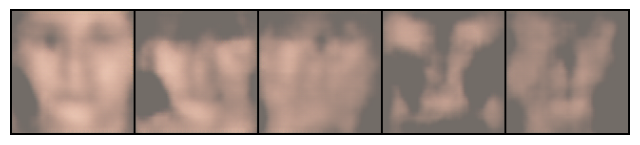

In [ ]:

imshow(torchvision.utils.make_grid(samples.cpu()))


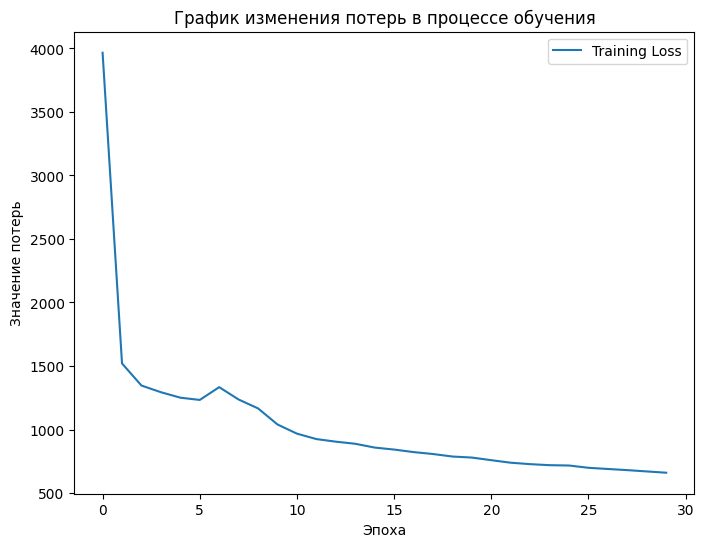

In [15]:
# --- Визуализация графика потерь ---
plot_loss(losses)

In [ ]:
# --- Уведомление о завершении обучения ---
url = "http://home.teyhd.ru:3334/"
params = {"msg": f"Обучение автоэнкодера завершено: Эпох {EPOCHS}\nФинальный лосс: {losses[-1]:.6f}"}
try:
    response = requests.get(url, params=params)
    print(f"Notification sent! Status Code: {response.status_code} | Response Text: {response.text}")
except Exception as e:
    print(f"Failed to send notification: {e}")


Notification sent! Status Code: 200 | Response Text: SENDING
